In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2023-11-21 05:03:31--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.170.207, 142.251.175.207, 74.125.24.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.170.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  20.4MB/s    in 4.0s    

2023-11-21 05:03:35 (16.2 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
# 압축풀기

import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
# 데이터 경로 설정
rootPath = '/tmp/cats_and_dogs_filtered'

# 훈련셋, 검증셋 경로
train_dir = os.path.join(rootPath, 'train') # /tmp/cats_and_dogs_filtered/train
validation_dir = os.path.join(rootPath, 'validation')  # /tmp/cats_and_dogs_filtered/validation

# 훈련셋 중에 고양이 사진 경로
train_cats_dir = os.path.join(train_dir, 'cats') # /tmp/cats_and_dogs_filtered/train/cats
# 훈련셋 중에 강아지 사진 경로
train_dogs_dir = os.path.join(train_dir, 'dogs') # /tmp/cats_and_dogs_filtered/train/dogs

# 검증셋 중에 고양이 사진 경로
validation_cats_dir = os.path.join(validation_dir, 'cats') # /tmp/cats_and_dogs_filtered/validation/cats
# 검증셋 중에 강아지 사진 경로
validation_dogs_dir = os.path.join(validation_dir, 'dogs') # /tmp/cats_and_dogs_filtered/validation/dogs

In [ ]:
train_cat_fnames = os.listdir(train_cats_dir)
train_cat_fnames.sort()
#print(train_cat_fnames[:10])

print('훈련 데이터 중 고양이 사진 수 : ', len(os.listdir(train_cats_dir)))
print('훈련 데이터 중 강아지 사진 수 : ', len(os.listdir(train_dogs_dir)))

print('검증 데이터 중 고양이 사진 수 : ', len(os.listdir(validation_cats_dir)))
print('검증 데이터 중 강아지 사진 수 : ', len(os.listdir(validation_dogs_dir)))

훈련 데이터 중 고양이 사진 수 :  1000
훈련 데이터 중 강아지 사진 수 :  1000
검증 데이터 중 고양이 사진 수 :  500
검증 데이터 중 강아지 사진 수 :  500


## 이미지 증식

In [ ]:
import os
from keras.preprocessing.image import ImageDataGenerator

# 데이터 경로 설정
rootPath = '/tmp/cats_and_dogs_filtered'

# 스케일링 + 데이터 증식 속성 설정
trainImageGenerator = ImageDataGenerator(rescale=1./255,
                                         horizontal_flip = True,
                                         vertical_flip = True,
                                         shear_range = 0.5,
                                         brightness_range = [0.5, 1.5],
                                         zoom_range = 0.2,
                                         width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         rotation_range = 30,
                                         fill_mode = 'nearest')

# 스케일링 설정
testImageGenerator =  ImageDataGenerator(rescale=1./255)


# 데이터 스케일링 및 증식
trainGen = trainImageGenerator.flow_from_directory(
    os.path.join(rootPath, 'train'),
    target_size=(64, 64),
    class_mode = 'binary'
)

testGen = testImageGenerator.flow_from_directory(
    os.path.join(rootPath, 'validation'),
    target_size=(64, 64),
    class_mode = 'binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
print(trainGen.class_indices)
print(testGen.class_indices)

{'cats': 0, 'dogs': 1}
{'cats': 0, 'dogs': 1}


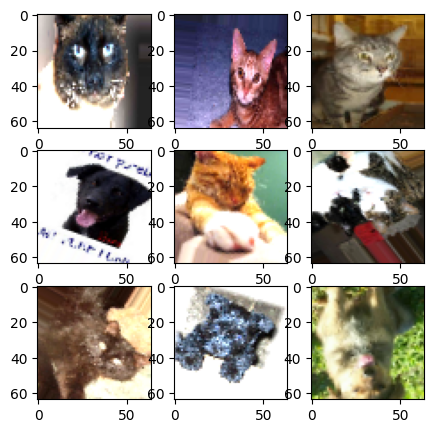

In [ ]:
from tensorflow.keras.preprocessing.image import array_to_img
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(5, 5))

for i in range(9):
  data = next(trainGen)
  arr = data[0][0]
  plt.subplot(3, 3, i+1)
  # plt.xticks([]) # 눈금 지우기
  # plt.yticks([])
  img = array_to_img(arr)
  plt.imshow(img)

plt.show()

사진 : ['cats']
사진 : 0


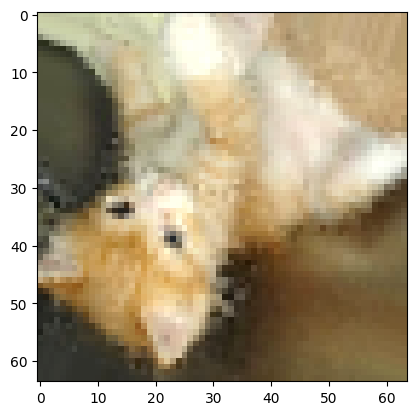

사진 : ['dogs']
사진 : 1


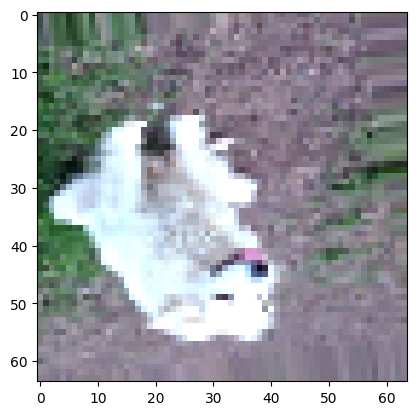

사진 : ['cats']
사진 : 0


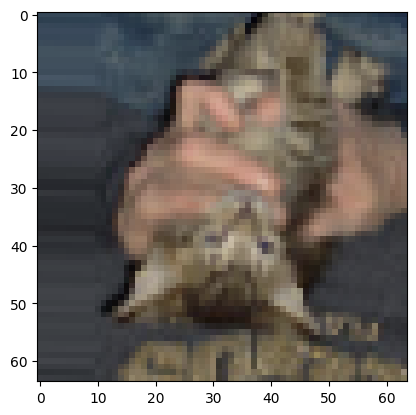

In [ ]:
label_index = trainGen.class_indices

# {'cats': 0, 'dogs': 1}
x, y = trainGen.next()

for i in range(0, 3):
  image = x[i]
  label = y[i].astype('int')
  # plt.xticks([]) # 눈금 지우기
  # plt.yticks([])
  print('사진 : {}'.format([k for k, v in label_index.items() if v == label]))
  print('사진 : {}'.format(label))
  plt.imshow(image)
  plt.show()

In [ ]:
from keras.models import Sequential
from keras import layers

model = Sequential()

model.add(layers.InputLayer(input_shape=(64, 64, 3)))
model.add(layers.Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size = (2,2)))
model.add(layers.Dropout(rate=0.3))

model.add(layers.Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size = (2,2)))
model.add(layers.Dropout(rate=0.3))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# 학습이 언제 자동 중단될지를 설정합니다.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=20)

# 최적화 모델이 저장될 폴더와 모델의 이름을 정합니다.
modelpath="./data/model/Ch14-4-bestmodel.hdf5"

# 최적화 모델을 업데이트하고 저장합니다.
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=0, save_best_only=True)

history = model.fit(trainGen, epochs = 64,
                    validation_data = testGen,
                    callbacks=[early_stopping_callback,checkpointer])

Epoch 1/64
63/63 [==============================] - 20s 146ms/step - loss: 0.7097 - acc: 0.4950 - val_loss: 0.6925 - val_acc: 0.5310


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/64
63/63 [==============================] - 10s 153ms/step - loss: 0.6904 - acc: 0.5360 - val_loss: 0.6920 - val_acc: 0.5100
Epoch 3/64
63/63 [==============================] - 8s 119ms/step - loss: 0.6894 - acc: 0.5370 - val_loss: 0.6929 - val_acc: 0.5000
Epoch 4/64
63/63 [==============================] - 9s 148ms/step - loss: 0.6897 - acc: 0.5420 - val_loss: 0.6812 - val_acc: 0.6070
Epoch 5/64
63/63 [==============================] - 11s 170ms/step - loss: 0.6762 - acc: 0.5680 - val_loss: 0.6598 - val_acc: 0.6190
Epoch 6/64
63/63 [==============================] - 10s 157ms/step - loss: 0.6642 - acc: 0.5835 - val_loss: 0.6604 - val_acc: 0.6020
Epoch 7/64
63/63 [==============================] - 11s 177ms/step - loss: 0.6580 - acc: 0.5880 - val_loss: 0.6719 - val_acc: 0.5920
Epoch 8/64
63/63 [==============================] - 7s 116ms/step - loss: 0.6484 - acc: 0.6225 - val_loss: 0.6445 - val_acc: 0.6190
Epoch 9/64
63/63 [==============================] - 10s 151ms/step - los

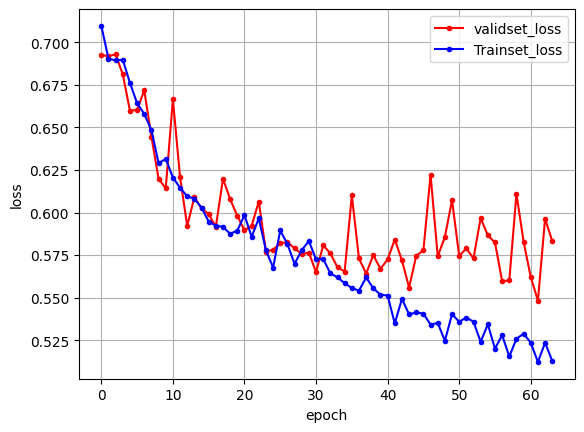

In [ ]:
# 검증셋과 학습셋의 오차 그래프
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프 생성
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='validset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

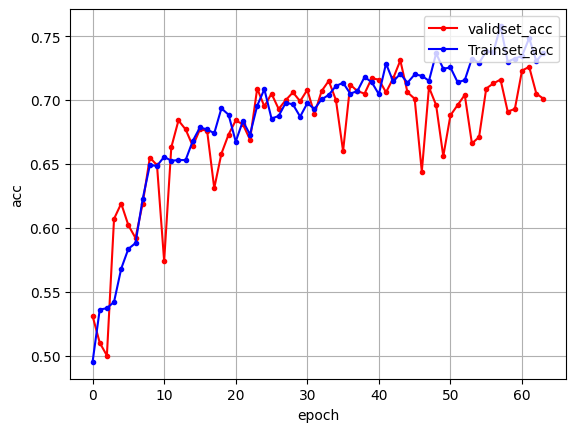

In [ ]:
# 검증셋과 학습셋의 오차를 저장합니다.
y_vacc = history.history['val_acc']
y_acc = history.history['acc']

# 그래프로 표현해 봅니다.
x_len = np.arange(len(y_acc))
plt.plot(x_len, y_vacc, marker='.', c="red", label='validset_acc')
plt.plot(x_len, y_acc, marker='.', c="blue", label='Trainset_acc')

# 그래프에 그리드를 주고 레이블을 표시해 보겠습니다.
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()

1/1 [==============================] - 0s 19ms/step
정답: 고양이  label : 0
예측: 고양이  predicted value : [[0.28218517]]


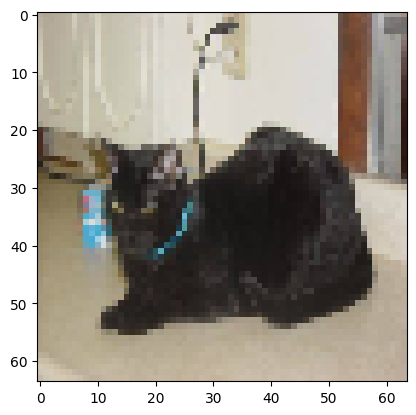

1/1 [==============================] - 0s 28ms/step
정답: 강아지  label : 1
예측: 강아지  predicted value : [[0.53954583]]


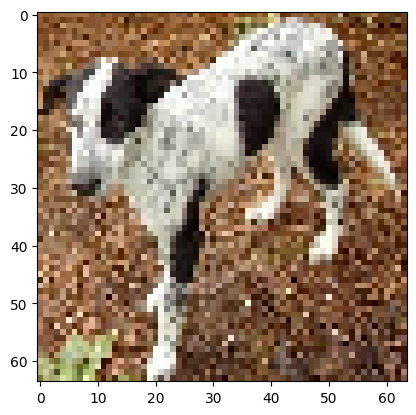

1/1 [==============================] - 0s 107ms/step
정답: 고양이  label : 0
예측: 고양이  predicted value : [[0.16309838]]


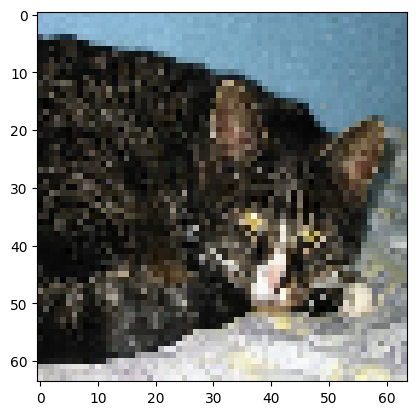

1/1 [==============================] - 0s 84ms/step
정답: 고양이  label : 0
예측: 고양이  predicted value : [[0.17769112]]


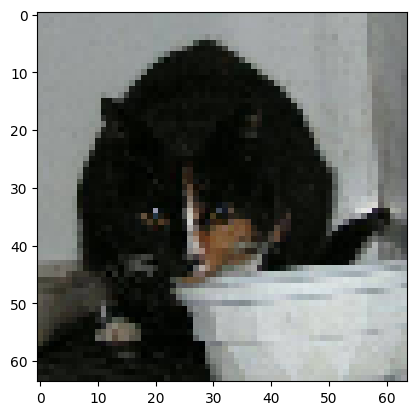

1/1 [==============================] - 0s 29ms/step
정답: 고양이  label : 0
예측: 고양이  predicted value : [[0.42399827]]


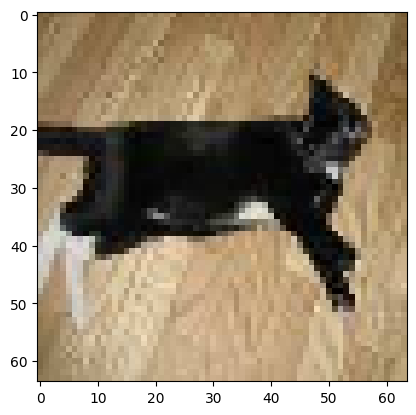

In [ ]:
from tensorflow.keras.preprocessing.image import array_to_img
import numpy as np

label_index = ['고양이', '강아지']

x, y = testGen.next()
for i in range(0,5):
  image = x[i]
  label = y[i].astype('int')

  y_prob = model.predict(image.reshape(1, 64, 64, 3))
  y_prob_class = (model.predict(image.reshape(1, 64, 64, 3)) > 0.5 ).astype('int')[0][0]
  print('정답: {}'.format(label_index[label]), ' label :', label)
  print('예측: {}'.format(label_index[y_prob_class]), ' predicted value :', y_prob)
  plt.imshow(image)
  plt.show()